In [1]:
import pandas as pd
import numpy as np
import re
import string

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

C:\Users\Mnesoma\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# Initializing a lemmatizer
lemmatizer = WordNetLemmatizer()

In [6]:
# Lets open the file and and extract all the content line by line into a list
with open('bbchealth.txt') as file:
    contents = file.readlines()
    
# Fancy regex for extracting data. Because I'm awesome and I refuse to split it.
regex = re.compile(r'(?P<tweet_id>.*)\|(?P<date>.*)\|(?P<news>.*)\s?(?P<link>http://.*)')

In [7]:
 #I hope the regex words
re.search(regex, contents[0]).groupdict()


{'tweet_id': '585978391360221184',
 'date': 'Thu Apr 09 01:31:50 +0000 2015',
 'news': 'Breast cancer risk test devised ',
 'link': 'http://bbc.in/1CimpJF'}

In [8]:
df = pd.DataFrame(columns=['tweet_id', 'date', 'news', 'link'])

# Self explanatory
for line in contents:
    line_data = re.search(regex, line).groupdict()
    df = df.append(line_data, ignore_index=True)

In [9]:
df.head()

,tweet_id,date,news,link
0,585978391360221184,Thu Apr 09 01:31:50 +0000 2015,Breast cancer risk test devised,http://bbc.in/1CimpJF
1,585947808772960257,Wed Apr 08 23:30:18 +0000 2015,GP workload harming care - BMA poll,http://bbc.in/1ChTBRv
2,585947807816650752,Wed Apr 08 23:30:18 +0000 2015,Short people's 'heart risk greater',http://bbc.in/1ChTANp
3,585866060991078401,Wed Apr 08 18:05:28 +0000 2015,New approach against HIV 'promising',http://bbc.in/1E6jAjt
4,585794106170839041,Wed Apr 08 13:19:33 +0000 2015,Coalition 'undermined NHS' - doctors,http://bbc.in/1CnLwK7


In [10]:
def normalize(line):
    line = line.lower().strip()
    line = ''.join([char for char in line if char not in string.punctuation+string.digits])
    return word_tokenize(line)

# Lemmatizing each word in each line
def lemmatize_sent(line_tokens):
    return list(map(lemmatizer.lemmatize, line_tokens))

# POS tagging, This one returns just the POS tags in order.
def tokens(line_tokens):
    word_tags = pos_tag(line_tokens)
    return list(zip(*word_tags))[1]

In [17]:
# Let's apply all those functions to the columns.
df['news_tokens'] = df['news'].map(normalize)
df['corresponding_tags'] = df['news_tokens'].map(tokens)
df['lemmatized_news_tokens'] = df['news_tokens'].map(lemmatize_sent)

In [18]:
# Dropping unnecessary columns, that I think I don't need.
df.drop(labels=['link'], inplace=True, axis=1)
df.drop(labels=['tweet_id'], inplace=True, axis=1)

In [19]:
df.head()

,date,news,news_tokens,corresponding_tags,lemmatized_news_tokens
0,Thu Apr 09 01:31:50 +0000 2015,Breast cancer risk test devised,"[breast, cancer, risk, test, devised]","(NN, NN, NN, NN, VBD)","[breast, cancer, risk, test, devised]"
1,Wed Apr 08 23:30:18 +0000 2015,GP workload harming care - BMA poll,"[gp, workload, harming, care, bma, poll]","(NN, NN, VBG, NN, NN, NN)","[gp, workload, harming, care, bma, poll]"
2,Wed Apr 08 23:30:18 +0000 2015,Short people's 'heart risk greater',"[short, peoples, heart, risk, greater]","(JJ, NNS, NN, NN, JJR)","[short, people, heart, risk, greater]"
3,Wed Apr 08 18:05:28 +0000 2015,New approach against HIV 'promising',"[new, approach, against, hiv, promising]","(JJ, NN, IN, NN, NN)","[new, approach, against, hiv, promising]"
4,Wed Apr 08 13:19:33 +0000 2015,Coalition 'undermined NHS' - doctors,"[coalition, undermined, nhs, doctors]","(NN, VBD, JJ, NNS)","[coalition, undermined, nh, doctor]"


In [20]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['lemmatized_news_tokens'].map(lambda x: ' '.join(x)).tolist())


In [21]:
kmeans = KMeans()
kmeans.fit(tfidf_matrix)

KMeans()

In [22]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [23]:
tfidf_matrix


<3929x3955 sparse matrix of type '<class 'numpy.float64'>'
	with 22123 stored elements in Compressed Sparse Row format>

In [24]:
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(tfidf_matrix.A)

(-0.4, 0.4)

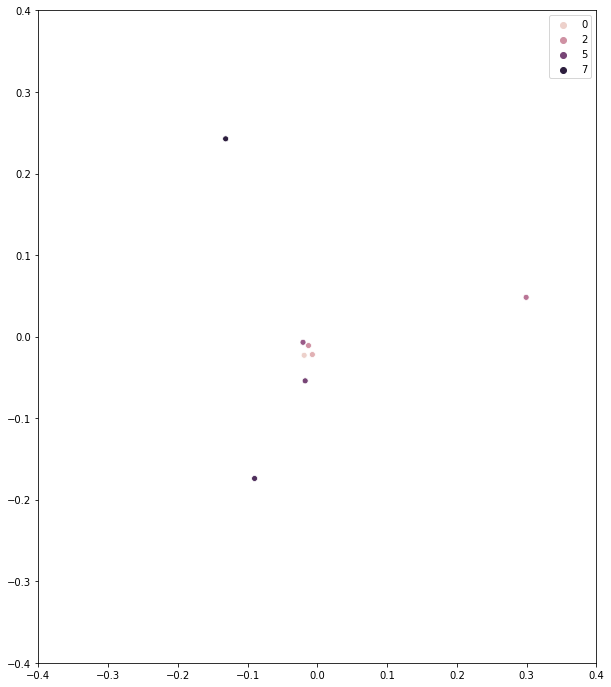

In [26]:
# Let's plot the cluster centers
plt.figure(figsize=(10, 12))
cluster_centers = pca.fit_transform(kmeans.cluster_centers_)
sns.scatterplot(x=cluster_centers[:,0], y=cluster_centers[:,1], hue=np.unique(kmeans.labels_))
    
plt.xlim((-0.4, 0.4))
plt.ylim((-0.4, 0.4))

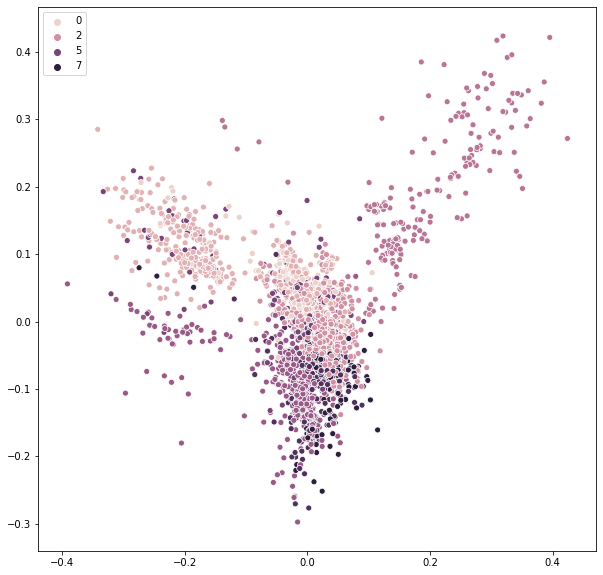

In [27]:
# Plotting the whole data, we get the following graph.
plt.figure(figsize=(10, 10))
sns.scatterplot(x=pca_matrix[:,0], y=pca_matrix[:,1], hue=kmeans.labels_)

In [28]:
pca_3d = PCA(n_components=3)
pca_matrix_3d = pca_3d.fit_transform(tfidf_matrix.A)

IndexError: string index out of range

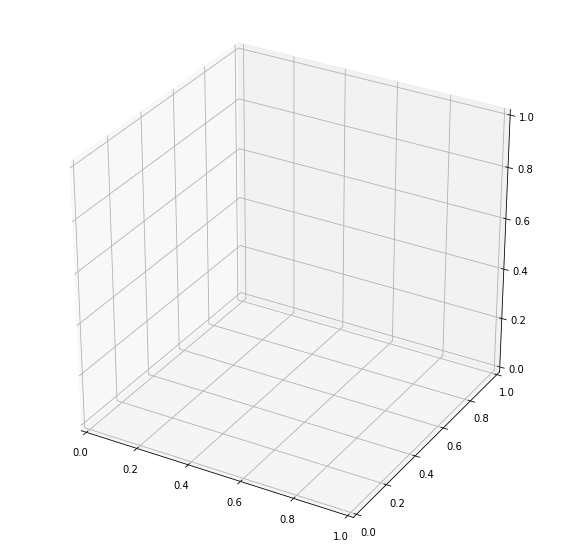

In [33]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for p, l in zip(pca_matrix_3d, kmeans.labels_):
    plt.scatter(*p, 'bgrcmykw'[l])

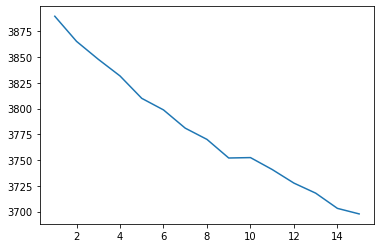

In [30]:
x, y = [], []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf_matrix)
    x.append(k)
    y.append(kmeans.inertia_)
    
plt.plot(x, y)

In [34]:
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    sil_score = silhouette_score(tfidf_matrix, kmeans.labels_)
    print('Number of clusters: {}, Silhoutte Score: {}'.format(k, sil_score))

Number of clusters: 2, Silhoutte Score: 0.0039069142419516836
Number of clusters: 3, Silhoutte Score: 0.00533201864638253
Number of clusters: 4, Silhoutte Score: 0.007050341158192584
Number of clusters: 5, Silhoutte Score: 0.008338589191881492
Number of clusters: 6, Silhoutte Score: 0.008800579300218114
Number of clusters: 7, Silhoutte Score: 0.010783101852968512
Number of clusters: 8, Silhoutte Score: 0.011289583365965129
Number of clusters: 9, Silhoutte Score: 0.012803511231606128
Number of clusters: 10, Silhoutte Score: 0.013032285815357727
Number of clusters: 11, Silhoutte Score: 0.013599254035209028
Number of clusters: 12, Silhoutte Score: 0.013569908262033198
Number of clusters: 13, Silhoutte Score: 0.014466797422918527
Number of clusters: 14, Silhoutte Score: 0.015564892043212326
Number of clusters: 15, Silhoutte Score: 0.01524974197281501
